# Text Generation with Amazon Bedrock

> *This notebook should work well with the **`Python 3`** kernel from **`SageMaker Distribution 2.1`** in SageMaker Studio*

## Introduction

In this notebook, you will explore different capabilities of Amazon Bedrock and how to use foundation models for the following use cases:

1. **Text Summarization**: Create concise summaries from longer text passages
2. **Code Generation**: Generate Python and SQL code from natural language descriptions
3. **Entity Extraction**: Extract structured information from unstructured text

You'll see how to use the unified Converse API to interact with different foundation models available through Amazon Bedrock, focusing primarily on the Amazon Nova family of models.

### Prerequisites
- Access to Amazon Bedrock
- Appropriate IAM permissions
- Python 3.x environment

In [1]:
import json
import sys
sys.path.append('../')
from util.model_selector import create_text_model_selector, bedrock, create_messages

# Create interactive model selector
model_selector = create_text_model_selector().display()

print("\n🎯 Select your preferred model above and run the cells below to see it in action!")


🎯 Select your preferred model above and run the cells below to see it in action!


## 1. Text Summarization: Create concise summaries from longer text passages

To learn the details of API requests to Amazon Bedrock, this notebook introduces how to use the unified Converse API which works consistently across all models, eliminating the need for model-specific formatting.

### Unified Converse API Benefits

The Converse API provides:
- **Consistent Interface**: Same API works for all text models (Nova, Claude, Titan, etc.)
- **Standardized Parameters**: Unified inference configuration
- **Simplified Integration**: No need for model-specific body formatting
- **Future Proof**: New models work automatically without code changes

### Writing prompt with text to be summarized

In this notebook, you can use any short text whose tokens are less than the maximum token of a foundation model. As an example of short text, let's take one paragraph of an [AWS blog post](https://aws.amazon.com/jp/blogs/machine-learning/announcing-new-tools-for-building-with-generative-ai-on-aws/) about announcement of Amazon Bedrock.

The prompt starts with an instruction `Please provide a summary of the following text.`, and includes text surrounded by `<text>` tag.

In [2]:
prompt = """
Please provide a summary of the following text. Do not add any information that is not mentioned in the text below.

<text>
AWS took all of that feedback from customers, and today we are excited to announce Amazon Bedrock, \
a new service that makes FMs from AI21 Labs, Anthropic, Stability AI, and Amazon accessible via an API. \
Bedrock is the easiest way for customers to build and scale generative AI-based applications using FMs, \
democratizing access for all builders. Bedrock will offer the ability to access a range of powerful FMs \
for text and images—including Amazons Titan FMs, which consist of two new LLMs we're also announcing \
today—through a scalable, reliable, and secure AWS managed service. With Bedrock's serverless experience, \
customers can easily find the right model for what they're trying to get done, get started quickly, privately \
customize FMs with their own data, and easily integrate and deploy them into their applications using the AWS \
tools and capabilities they are familiar with, without having to manage any infrastructure (including integrations \
with Amazon SageMaker ML features like Experiments to test different models and Pipelines to manage their FMs at scale).
</text>

"""

### Invoke foundation model via Unified Converse API

This section demonstrates how to send API requests to Amazon Bedrock using the unified Converse API. The beauty of this approach is that the same code works with any text model - you just change the model selection above!

The foundation model will process the input based on the provided prompt and model-specific configuration parameters. In the following example, the foundation model in Amazon Bedrock summarizes the text.

In [ ]:
# Get the selected model
selected_model = model_selector.get_model_id()
model_info = model_selector.get_model_info()

print(f"Using model: {model_info['name']} ({selected_model})")
print(f"Description: {model_info['description']}")
print("\n" + "="*50 + "\n")

# Create messages using our helper function
messages = create_messages(prompt)

print(f"Sending messages:\n{json.dumps(messages, indent=4)}")

# Invoke the model using unified API
try:
    response = bedrock.converse(
        model_id=selected_model,
        messages=messages,
        max_tokens=300,
        temperature=0.3,
        top_p=0.9
    )
    
    if response:
        print("📝 Summary:")
        print(response)
    else:
        print("❌ Failed to generate response")
        
except Exception as error:
    print(f"❌ Error: {str(error)}")
    print("\nTo troubleshoot this issue please refer to the following resources:")
    print("https://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html")
    print("https://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html")

Using model: Nova Lite (us.amazon.nova-lite-v1:0)
Description: Fast, cost-effective text generation


Sending messages:
[
    {
        "role": "user",
        "content": [
            {
                "text": "\nPlease provide a summary of the following text. Do not add any information that is not mentioned in the text below.\n\n<text>\nAWS took all of that feedback from customers, and today we are excited to announce Amazon Bedrock, a new service that makes FMs from AI21 Labs, Anthropic, Stability AI, and Amazon accessible via an API. Bedrock is the easiest way for customers to build and scale generative AI-based applications using FMs, democratizing access for all builders. Bedrock will offer the ability to access a range of powerful FMs for text and images\u2014including Amazons Titan FMs, which consist of two new LLMs we're also announcing today\u2014through a scalable, reliable, and secure AWS managed service. With Bedrock's serverless experience, customers can easily find the r

### Compare Different Models

The beauty of our unified system is that you can easily compare different models by simply changing the selection above and re-running the cell. Try selecting different models to see how they perform on the same task!

### Conclusion on Text Summarization

You have now experimented with using the unified Converse API which provides a consistent interface across all Amazon Bedrock models. Using this API you have seen the use case of generating a summary of AWS news about Amazon Bedrock.

### Additional challenges

- Experiment with different models using the dropdown selector above
- Change the prompts to your specific usecase and evaluate the output of different models
- Play with the token length to understand the latency and responsiveness of the service
- Apply different prompt engineering principles to get better outputs

## 2. Code Generation: Generate Python and SQL code from natural language descriptions

### Introduction

In this section we show you how to use a LLM to generate code based on the text prompt. We will use the unified Converse API that works with any model you select.

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

**Note:** *This notebook can be run within or outside of AWS environment.*

##### Context
To demonstrate the code generation capability of Amazon Bedrock, we will explore the use of the unified Converse API. We will demonstrate different configurations available as well as how simple input can lead to desired outputs. We will explore code generation for two use cases:

1. Python code generation for analytical QnA
2. SQL query generation

##### Pattern

In both use cases, we will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model under the hood to generate an output without providing any additional example. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

### Use case 1 - Python code generation for Analytical QnA

To demonstrate the generation capability of models in Amazon Bedrock, let's take the use case of code generation with Python to do some basic analytical QnA.

##### Persona

You are Moe, a Data Analyst, at AnyCompany. The company wants to understand its sales performance for different products over the past year. You have been provided a dataset named sales.csv. The dataset contains the following columns:

- Date (YYYY-MM-DD) format
- Product_ID (unique identifier for each product)
- Price (price at which each product was sold)

##### Implementation

To fulfill this use case, in this notebook we will show how to generate code for a given prompt using our unified model selection system.

#### Lab setup - create sample sales.csv data for this lab.

Following on the use case explained above, let's prepare an input for the Amazon Bedrock service to generate python program for our use-case.

In [4]:
# create sales.csv file
import csv

data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

# Write data to sales.csv
with open('sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


#### Analyzing sales with Amazon Bedrock generated Python program

In [5]:
# Create the prompt for code generation
prompt_data = """
You have a CSV, sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, not span multiple lines unnecessarily, and prefer to use standard libraries. Return only python code without any surrounding text, explanation or context.
Do not use pandas library for the solution.
"""

Generate the code using the selected model:

In [6]:
from IPython.display import display, Markdown

# Get the selected model
selected_model = model_selector.get_model_id()
model_info = model_selector.get_model_info()

print(f"🔧 Generating Python code using: {model_info['name']}")
print("\n" + "="*50 + "\n")

# Create messages
messages = create_messages(prompt_data)

# Generate code
response = bedrock.converse(
    model_id=selected_model,
    messages=messages,
    max_tokens=4096,
    temperature=0.1,
    top_p=0.99
)

if response:
    print("📋 Generated Python Code:")
    display(Markdown(f"```python\n{response}\n```"))
else:
    print("❌ Failed to generate code")

🔧 Generating Python code using: Nova Lite


📋 Generated Python Code:


```python
```python
import csv
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

def read_csv(file_path):
    sales_data = []
    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            sales_data.append(row)
    return sales_data

def calculate_total_revenue(sales_data):
    total_revenue = 0
    for sale in sales_data:
        total_revenue += float(sale['price']) * int(sale['units_sold'])
    return total_revenue

def find_product_with_highest_revenue(sales_data):
    product_revenue = defaultdict(float)
    for sale in sales_data:
        product_id = sale['product_id']
        revenue = float(sale['price']) * int(sale['units_sold'])
        product_revenue[product_id] += revenue
    max_revenue_product = max(product_revenue, key=product_revenue.get)
    return max_revenue_product, product_revenue[max_revenue_product]

def find_date_with_highest_revenue(sales_data):
    date_revenue = defaultdict(float)
    for sale in sales_data:
        date = sale['date']
        revenue = float(sale['price']) * int(sale['units_sold'])
        date_revenue[date] += revenue
    max_revenue_date = max(date_revenue, key=date_revenue.get)
    return max_revenue_date, date_revenue[max_revenue_date]

def visualize_monthly_sales(sales_data):
    monthly_sales = defaultdict(int)
    for sale in sales_data:
        month = sale['date'][:7]
        units_sold = int(sale['units_sold'])
        monthly_sales[month] += units_sold
    months = sorted(monthly_sales.keys())
    units_sold = [monthly_sales[month] for month in months]
    plt.bar(months, units_sold)
    plt.xlabel('Month')
    plt.ylabel('Units Sold')
    plt.title('Monthly Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main(file_path):
    sales_data = read_csv(file_path)
    total_revenue = calculate_total_revenue(sales_data)
    product, product_revenue = find_product_with_highest_revenue(sales_data)
    date, date_revenue = find_date_with_highest_revenue(sales_data)
    visualize_monthly_sales(sales_data)
    print(f"Total Revenue for the Year: ${total_revenue:.2f}")
    print(f"Product with the Highest Revenue: {product} (${product_revenue:.2f})")
    print(f"Date with the Highest Revenue: {date} (${date_revenue:.2f})")

if __name__ == "__main__":
    main('sales.csv')
```
```

#### (Optional) Execute the Bedrock generated code for validation

Copy the generated code from above and paste it in the cell below to test it:

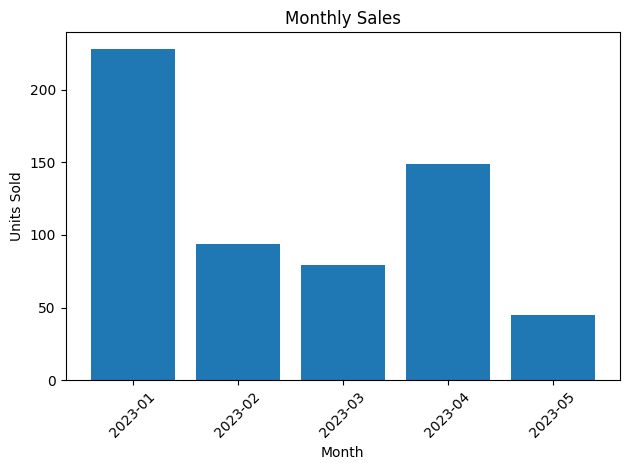

Total Revenue for the Year: $35490.00
Product with the Highest Revenue: P003 ($14910.00)
Date with the Highest Revenue: 2023-04-23 ($2380.00)


In [26]:
import csv
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

def read_csv(file_path):
    sales_data = []
    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            sales_data.append(row)
    return sales_data

def calculate_total_revenue(sales_data):
    total_revenue = 0
    for sale in sales_data:
        total_revenue += float(sale['price']) * int(sale['units_sold'])
    return total_revenue

def find_product_with_highest_revenue(sales_data):
    product_revenue = defaultdict(float)
    for sale in sales_data:
        product_id = sale['product_id']
        revenue = float(sale['price']) * int(sale['units_sold'])
        product_revenue[product_id] += revenue
    max_revenue_product = max(product_revenue, key=product_revenue.get)
    return max_revenue_product, product_revenue[max_revenue_product]

def find_date_with_highest_revenue(sales_data):
    date_revenue = defaultdict(float)
    for sale in sales_data:
        date = sale['date']
        revenue = float(sale['price']) * int(sale['units_sold'])
        date_revenue[date] += revenue
    max_revenue_date = max(date_revenue, key=date_revenue.get)
    return max_revenue_date, date_revenue[max_revenue_date]

def visualize_monthly_sales(sales_data):
    monthly_sales = defaultdict(int)
    for sale in sales_data:
        month = sale['date'][:7]
        units_sold = int(sale['units_sold'])
        monthly_sales[month] += units_sold
    months = sorted(monthly_sales.keys())
    units_sold = [monthly_sales[month] for month in months]
    plt.bar(months, units_sold)
    plt.xlabel('Month')
    plt.ylabel('Units Sold')
    plt.title('Monthly Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main(file_path):
    sales_data = read_csv(file_path)
    total_revenue = calculate_total_revenue(sales_data)
    product, product_revenue = find_product_with_highest_revenue(sales_data)
    date, date_revenue = find_date_with_highest_revenue(sales_data)
    visualize_monthly_sales(sales_data)
    print(f"Total Revenue for the Year: ${total_revenue:.2f}")
    print(f"Product with the Highest Revenue: {product} (${product_revenue:.2f})")
    print(f"Date with the Highest Revenue: {date} (${date_revenue:.2f})")

if __name__ == "__main__":
    main('sales.csv')

### Use case 2 - SQL query generation

In this section we show you how to use a LLM to generate SQL queries to analyze Sales data. We will use Amazon Nova Pro model using the Boto3 API. 

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

##### Pattern
We will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model to generate an output without providing any additional examples. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

##### Use case
Let's take the use case to generate SQL queries to analyze sales data, focusing on top products and average monthly sales.

##### Persona
Maya is a business analyst, at AnyCompany primarily focusing on sales and inventory data. She is transitioning from Speadsheet analysis to data-driven analysis and want to use SQL to fetch specific data points effectively. She wants to use LLMs to generate SQL queries for her analysis. 

##### Implementation
To fulfill this use case, in this notebook we will show how to generate SQL queries. We will use the Amazon Nova Pro model using the Amazon Bedrock API with Boto3 client. 

#### Generate SQL Query

Following on the use case explained above, let's prepare an input for  the Amazon Bedrock service to generate some SQL queries.

In [27]:
# create the prompt to generate SQL query
prompt_data = """
AnyCompany has a database with a table named sales_data containing sales records. The table has following columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Can you generate SQL queries for the below: 
- Identify the top 5 best selling products by total sales for the year 2023
- Calculate the average of total monthly sales for the year 2023

- use CTE queries formatique
"""

In [28]:
from IPython.display import display, Markdown

# Get the selected model
selected_model = model_selector.get_model_id()
model_info = model_selector.get_model_info()

print(f"🗄️ Generating SQL queries using: {model_info['name']}")
print("\n" + "="*50 + "\n")

# Create messages
messages = create_messages(prompt_data)

# Generate SQL using unified Converse API
response = bedrock.converse(
    model_id=selected_model,
    messages=messages,
    max_tokens=4096,
    temperature=0.1,
    top_p=0.99
)

if response:
    print("📊 Generated SQL Queries:")
    display(Markdown(response))
else:
    print("❌ Failed to generate SQL queries")


🗄️ Generating SQL queries using: Nova Lite


📊 Generated SQL Queries:


Certainly! Below are the SQL queries using Common Table Expressions (CTEs) to achieve the specified tasks:

### Query 1: Identify the top 5 best selling products by total sales for the year 2023

```sql
WITH TotalSales AS (
    SELECT
        product_id,
        SUM(units_sold) AS total_units_sold
    FROM
        sales_data
    WHERE
        date >= '2023-01-01' AND date < '2024-01-01'
    GROUP BY
        product_id
)
SELECT
    product_id,
    total_units_sold
FROM
    TotalSales
ORDER BY
    total_units_sold DESC
LIMIT 5;
```

### Query 2: Calculate the average of total monthly sales for the year 2023

```sql
WITH MonthlySales AS (
    SELECT
        DATE_TRUNC('month', date) AS month,
        SUM(units_sold) AS total_units_sold
    FROM
        sales_data
    WHERE
        date >= '2023-01-01' AND date < '2024-01-01'
    GROUP BY
        month
),
TotalMonthlySales AS (
    SELECT
        COUNT(*) AS total_months,
        AVG(total_units_sold) AS avg_monthly_sales
    FROM
        MonthlySales
)
SELECT
    avg_monthly_sales
FROM
    TotalMonthlySales;
```

### Explanation:

1. **Top 5 Best Selling Products by Total Sales for 2023:**
    - **CTE (TotalSales):** This CTE calculates the total units sold for each product in the year 2023.
    - The main query selects the top 5 products by total units sold, ordering the results in descending order and limiting the output to 5 rows.

2. **Average of Total Monthly Sales for 2023:**
    - **CTE (MonthlySales):** This CTE calculates the total units sold for each month in the year 2023.
    - **CTE (TotalMonthlySales):** This CTE calculates the total number of months and the average of total units sold per month.
    - The main query selects the average monthly sales from the `TotalMonthlySales` CTE.

### Conclusion on Code Generation
You have now experimented with using `boto3` SDK which provides a vanilla exposure to Amazon Bedrock API. Using this API you generate a python program to analyze and visualize given sales data, and generate SQL statements based on an input task and schema.

## 3. Entity Extraction: Extract structured information from unstructured text

### Context
Entity extraction is an NLP technique that allows us to automatically extract specific data from naturally written text, such as news, emails, books, etc.
That data can then later be saved to a database, used for lookup or any other type of processing.

Classic entity extraction programs usually limit you to pre-defined classes, such as name, address, price, etc. or require you to provide many examples of types of entities you are interested in.
By using a LLM for entity extraction, in most cases you are only required to specify what you need to extract in natural language. This gives you flexibility and accuracy in your queries, while saving time by removing the need for data labeling.

In addition, LLM entity extraction can be used to help you assemble a dataset to create a customised solution for your use case, such as [Amazon Comprehend custom entity](https://docs.aws.amazon.com/comprehend/latest/dg/custom-entity-recognition.html) recognition.

### Entity Extraction

For this exercise we will pretend to be an online bookstore that receives questions and orders by email.
Our task is to extract relevant information from the email to process the order.

Let's begin by taking a look at the sample email:

In [10]:
from pathlib import Path

emails_dir = Path(".") / "emails"
with open(emails_dir / "00_treasure_island.txt") as f:
    book_question_email = f.read()

print(book_question_email)

Dear Sir or Madam,

I would like to order Treasure Island, do you have it in stock?

Also, is it possible to pay by cheque?

Yours sincerely,
John Smith


### Basic approach

First, let's define a function to process queries using our selected model. In the below, we use a system prompt to tell the
LLM to act as a bookstore assistant.

In [11]:
def bookstore_assistant(query: str) -> str:
    """
    Process bookstore queries using the unified Converse API with the selected model.
    """
    # Get the selected model
    selected_model = model_selector.get_model_id()
    
    # Create messages - just the user message
    messages = create_messages(query)
    
    # Use unified Converse API with system message parameter
    response = bedrock.converse(
        model_id=selected_model,
        messages=messages,
        max_tokens=4096,
        temperature=0.1,
        top_p=0.99
    )
    
    return response if response else ""

For basic cases we can directly ask the model to return the result. Let's try extracting the name of the book.

In [12]:
query = f"""
Given the email inside triple-backticks, please read it and analyse the contents.
If a name of a book is mentioned, return it, otherwise return nothing.

Email: ```
{book_question_email}
```

"""

In [13]:
result = bookstore_assistant(query)
print(result)

The book mentioned in the email is "Treasure Island". The sender, John Smith, is inquiring about the availability of the book and also asking if it is possible to pay by cheque.


### Model specific prompts

While basic approach works, to achieve best results we recommend to apply prompt engineering approaches according to the best practices of the used model e.g. [Amazon Nova's prompting best practices](https://docs.aws.amazon.com/nova/latest/userguide/prompting.html), or [Anthropic's prompt engineering](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/).

Here is an example prompt for Anthropic's recommendation to [use XML tags](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/use-xml-tags):

In [14]:
prompt = """

Given the email provided, please read it and analyse the contents.
If a name of a book is mentioned, return it.
If no name is mentioned, return empty string.
The email will be given between <email></email> XML tags.

<email>
{email}
</email>

Return the name of the book between <book></book> XML tags.

"""
query = prompt.format(email=book_question_email)

In [15]:
result = bookstore_assistant(query)
print(result)

<book>Treasure Island</book>


To extract results easier, we can use a helper function:

In [16]:
from bs4 import BeautifulSoup

def extract_by_tag(response: str, tag: str, extract_all=False) -> str | list[str] | None:
    soup = BeautifulSoup(response)
    results = soup.find_all(tag)
    if not results:
        return
        
    texts = [res.get_text() for res in results]
    if extract_all:
        return texts
    return texts[-1]

In [17]:
extract_by_tag(result, "book")

'Treasure Island'

We can check that our model doesn't return arbitrary results when no appropriate information is given (also know as 'hallucination'), by running our prompt on other emails.

In [18]:
with open(emails_dir / "01_return.txt") as f:
    return_email = f.read()

print(return_email)

I didn't like the last book I ordered and would like to return it.


In [19]:
query = prompt.format(email=return_email)
result = bookstore_assistant(query)
print(result)

<book></book>

Since there is no name of a book mentioned in the email, the output is an empty string between <book></book> XML tags.


Using tags also allows us to extract multiple pieces of information at the same time and makes extraction much easier.
In the following prompt we will extract not just the book name, but any questions, requests and customer name.

In [20]:
prompt = """
Given email provided , please read it and analyse the contents.

Please extract the following information from the email:
- Any questions the customer is asking, return it inside <questions></questions> XML tags.
- The customer's full name, return it inside <name></name> XML tags.
- Any book names the customer mentions, return it inside <books></books> XML tags.

If a particular bit of information is not present, return an empty string.
Make sure that each question can be understoon by itself, incorporate context if requred.
Each returned question should be concise, remove extra information if possible.
The email will be given between <email></email> XML tags.

<email>
{email}
</email>

Return each question inside <question></question> XML tags.
Return the name of each book inside <book></book> XML tags.
"""

In [21]:
query = prompt.format(email=book_question_email)
result = bookstore_assistant(query)
print(result)

<analysis>
  <questions>
    <question>I would like to order Treasure Island, do you have it in stock?</question>
    <question>Is it possible to pay by cheque?</question>
  </questions>
  <name>John Smith</name>
  <books>
    <book>Treasure Island</book>
  </books>
</analysis>


In [22]:
extract_by_tag(result, "question", extract_all=True)

['I would like to order Treasure Island, do you have it in stock?',
 'Is it possible to pay by cheque?']

In [23]:
extract_by_tag(result, "name")

'John Smith'

In [24]:
extract_by_tag(result, "book", extract_all=True)

['Treasure Island']

### Conclusion on Entity Extraction

Entity extraction is a powerful technique which can extract arbitrary data from plain text descriptions.

This is particularly useful when you need to extract specific data which doesn't have clear structure. In such cases regex and other traditional extraction techniques can be very difficult to implement.

### Additional Challenges
-  Review the [Claude prompt guide](https://docs.anthropic.com/claude/docs/introduction-to-prompt-design) that includes prompt-engineering best practices.

- Your task is to complete the prompts in the following functions based on the prompt techniques you read in the Claude Prompt Guide. The examples use product categorization - 
classifying items into categories such as Kitchen Appliances, Electronics, Home & Garden, or Sports & Outdoors. Review the results and explore the effects of
different techniques on the output.

- For testing, modify the prompts, uncomment the run_all_examples() line, and execute the cell.

In [25]:
""" PROMPT ENGINEERING """
def zero_shot_example():
    """Zero-shot: Direct instruction without examples for product categorization"""
    prompt = """ COMPLETE PROMPT """
    
    messages = create_messages(prompt)
    response = bedrock.converse(
        model_id=model_selector.get_model_id(),
        messages=messages,
        max_tokens=500,
        temperature=0.1
    )
    return response

def few_shot_example():
    """Chain of Thought: Step-by-step reasoning for product categorization"""
    prompt = """ COMPLETE PROMPT """
    
    messages = create_messages(prompt)
    response = bedrock.converse(
        model_id=model_selector.get_model_id(),
        messages=messages,
        max_tokens=500,
        temperature=0.1
    )
    return response

def chain_of_thought_example():
    """Chain of Thought: Step-by-step reasoning"""
    prompt = """ COMPLETE PROMPT """
    
    messages = create_messages(prompt)
    response = bedrock.converse(
        model_id=model_selector.get_model_id(),
        messages=messages,
        max_tokens=500,
        temperature=0.1
    )
    return response

def run_all_examples():
    """Run all prompt engineering examples"""
    print("=== PROMPT ENGINEERING WITH BEDROCK ===\n")
    
    print("1. ZERO-SHOT RESULT:")
    print(zero_shot_example())
    print("\n" + "-"*50 + "\n")
    
    print("2. FEW-SHOT RESULT:")
    print(few_shot_example())
    print("\n" + "-"*50 + "\n")
    
    print("3. CHAIN OF THOUGHT RESULT:")
    print(chain_of_thought_example())
    print("\n" + "="*50)

# run_all_examples()

## Conclusion

In this notebook, we've explored text generation capabilities with Amazon Bedrock for the following use cases:

1. **Text Summarization**: Create concise summaries from longer text passages
2. **Code Generation**: Generate Python and SQL code from natural language descriptions
3. **Entity Extraction**: Extract structured information from unstructured text
